# 매개변수 갱신

## 확률적 경사 하강법(SGD)

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

## 모멘텀

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

## AdaGrad

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key]/ (np.sqrt(self.h[key]) + 1e-7)

## Adam

In [4]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

## 어느 갱신 방법을 이용할 것인가?

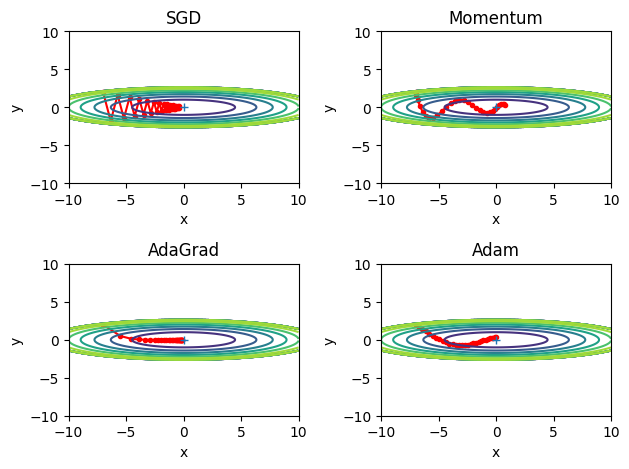

In [5]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y


init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = {}
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0

    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, '.-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    # colorbar()
    # spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.tight_layout()
plt.show()

## MNIST 데이터셋으로 본 갱신 방법 비교

### MNIST 데이터 읽기

In [7]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from dataset.mnist import load_mnist
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
# from common.optimizer import *

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

### 실험 설정

In [8]:
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
# optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []

### 학습

In [9]:
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
SGD:2.393576322859245
Momentum:2.3577758975187098
AdaGrad:2.1565051677684153
Adam:2.116021022127657
===========iteration:100===========
SGD:1.4466651675603304
Momentum:0.41580243815020446
AdaGrad:0.16735437843083653
Adam:0.23675599963325122
===========iteration:200===========
SGD:0.7249358656427385
Momentum:0.3154830182695262
AdaGrad:0.18282227555120417
Adam:0.2215921692346481
===========iteration:300===========
SGD:0.5561960948930784
Momentum:0.2513268206896146
AdaGrad:0.11088472504813163
Adam:0.17963740212308824
===========iteration:400===========
SGD:0.3365813240497257
Momentum:0.11956721406710528
AdaGrad:0.03470510637726016
Adam:0.07228901511181099
===========iteration:500===========
SGD:0.3722178158547479
Momentum:0.14182399197996579
AdaGrad:0.035233976129887955
Adam:0.0787484930912061
===========iteration:600===========
SGD:0.5093847113516341
Momentum:0.21634046239875981
AdaGrad:0.06310068169687508
Adam:0.07869951178250001
===========iteration:70

### 그래프 그리기

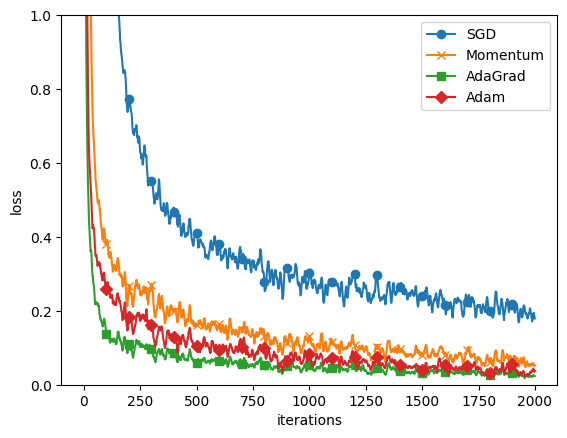

In [10]:
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key],
        markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

# 가중치의 초깃값

## 은닉층의 활성화값 분포

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.random.randn(1000, 100) # 1000x100 개의 데이터
node_num = 100 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} # 이곳에 활성화 결과(활성화값) 저장

for i in range(hidden_layer_size):
    if i !=0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

*히스토그램 그리기*

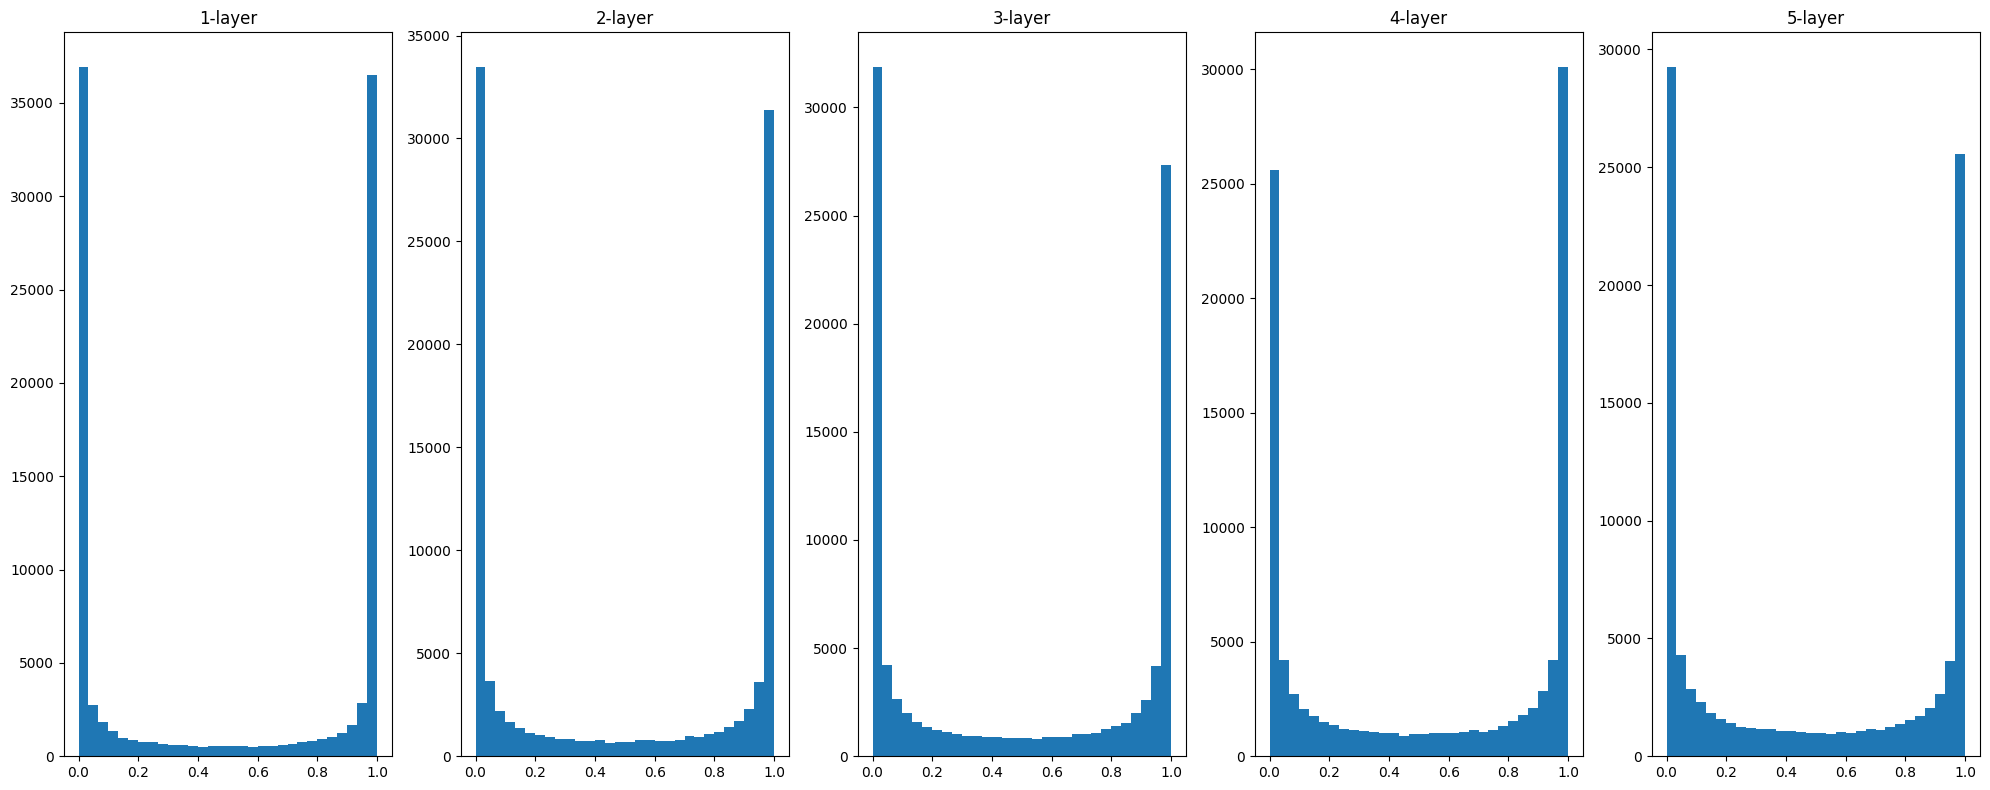

In [30]:
plt.figure(figsize=(20, 8))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1)+'-layer')
    min_value = a.min()  # Minimum value in the array
    max_value = a.max()  # Maximum value in the array
    plt.hist(a.flatten(), 30, range=(min_value, max_value))  # Set the valid range
plt.tight_layout()
plt.show()

*함수화*

In [64]:
def show_weights(act_fn, decay):
    import numpy as np
    import matplotlib.pyplot as plt
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def ReLU(x):
        return np.maximum(0, x)

    def tanh(x):
        return np.tanh(x)
    
    if decay == 'xavier':
        decay_str =  "Xavier : np.sqrt(1.0 / node_num)"
    elif decay == 'he':
        decay_str =  "He : np.sqrt(2.0 / node_num)"
    else:
        decay_str = str(decay)
    
    print(f'{act_fn}, {decay_str}')

    input_data = np.random.randn(1000, 100)  # 1000개의 데이터
    node_num = 100  # 각 은닉층의 노드(뉴런) 수
    hidden_layer_size = 5  # 은닉층이 5개
    activations = {}  # 이곳에 활성화 결과를 저장
    
    x = input_data

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        # 초깃값을 다양하게 바꿔가며 실험해보자！
        if decay == 'xavier':
            w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
        elif decay == 'he':
            w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
        else:
            w = np.random.randn(node_num, node_num) * decay

        a = np.dot(x, w)

        # 활성화 함수도 바꿔가며 실험해보자！
        if act_fn == 'relu':
            z = ReLU(a)
        elif act_fn == 'tanh':
            z = tanh(a)
        else:
            z = sigmoid(a)

        activations[i] = z

    # 히스토그램 그리기
    plt.figure(figsize=(15, 6))
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0:
            plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
        plt.hist(a.flatten(), 30, range=(0, 1))

#     plt.title(f'{act_fn}')
    plt.tight_layout()
    plt.show()     

*가중치의 표준 편차를 0.01*

softmax, 1


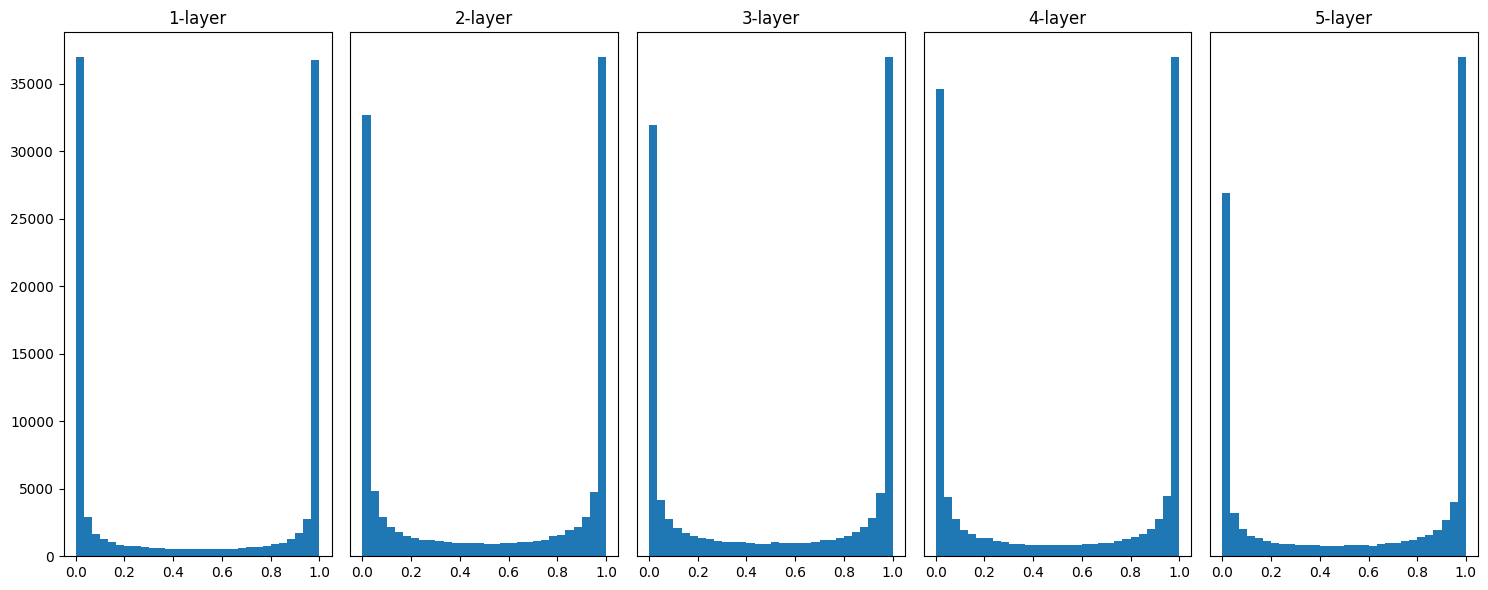

softmax, 0.01


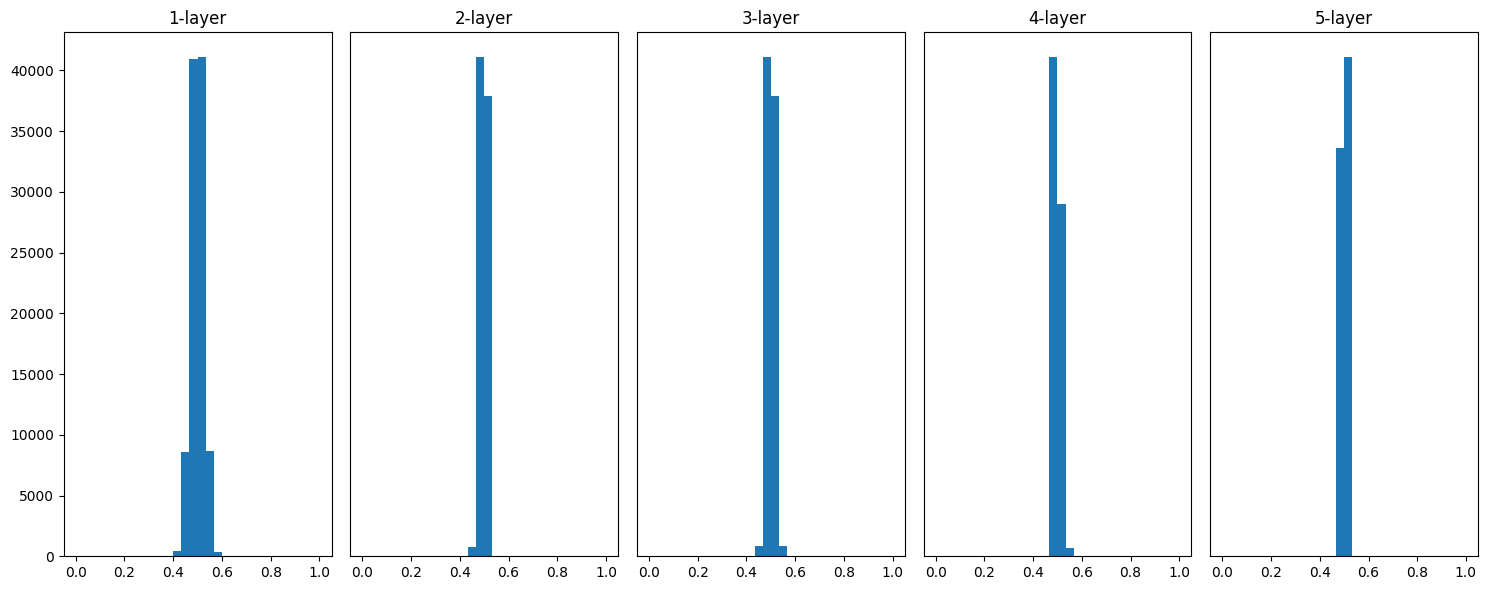

softmax, Xavier : np.sqrt(1.0 / node_num)


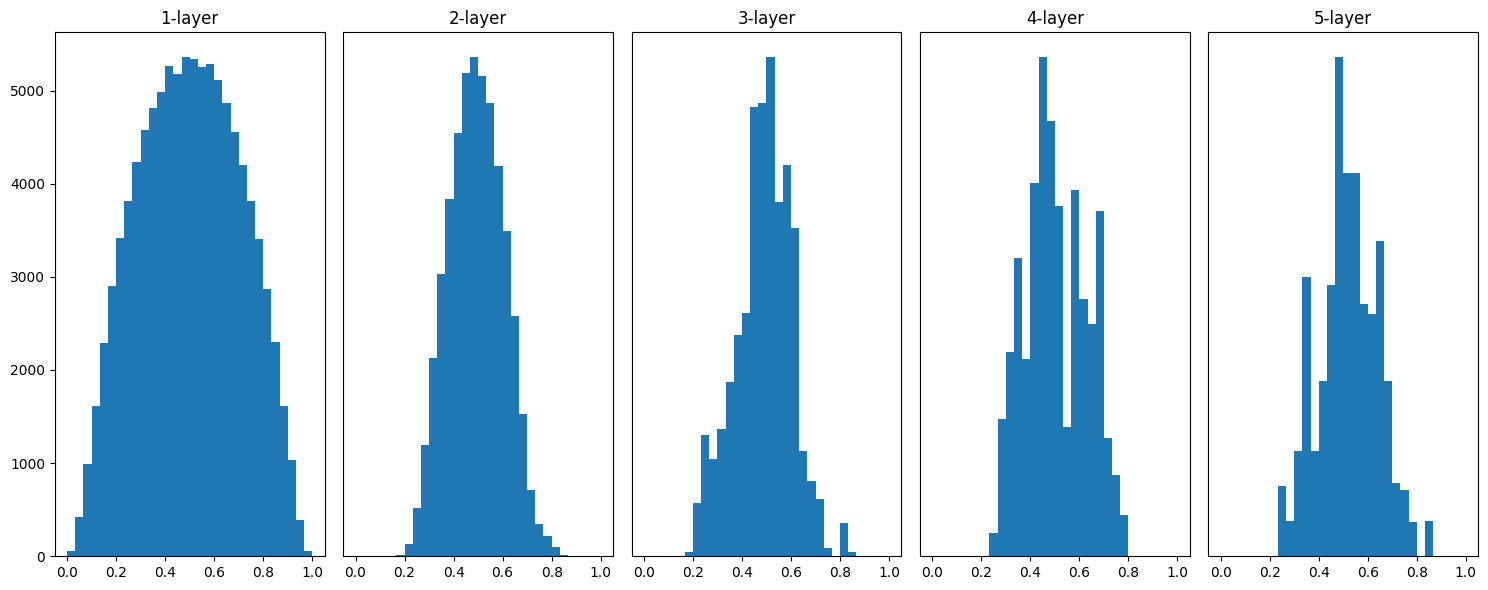

softmax, He : np.sqrt(2.0 / node_num)


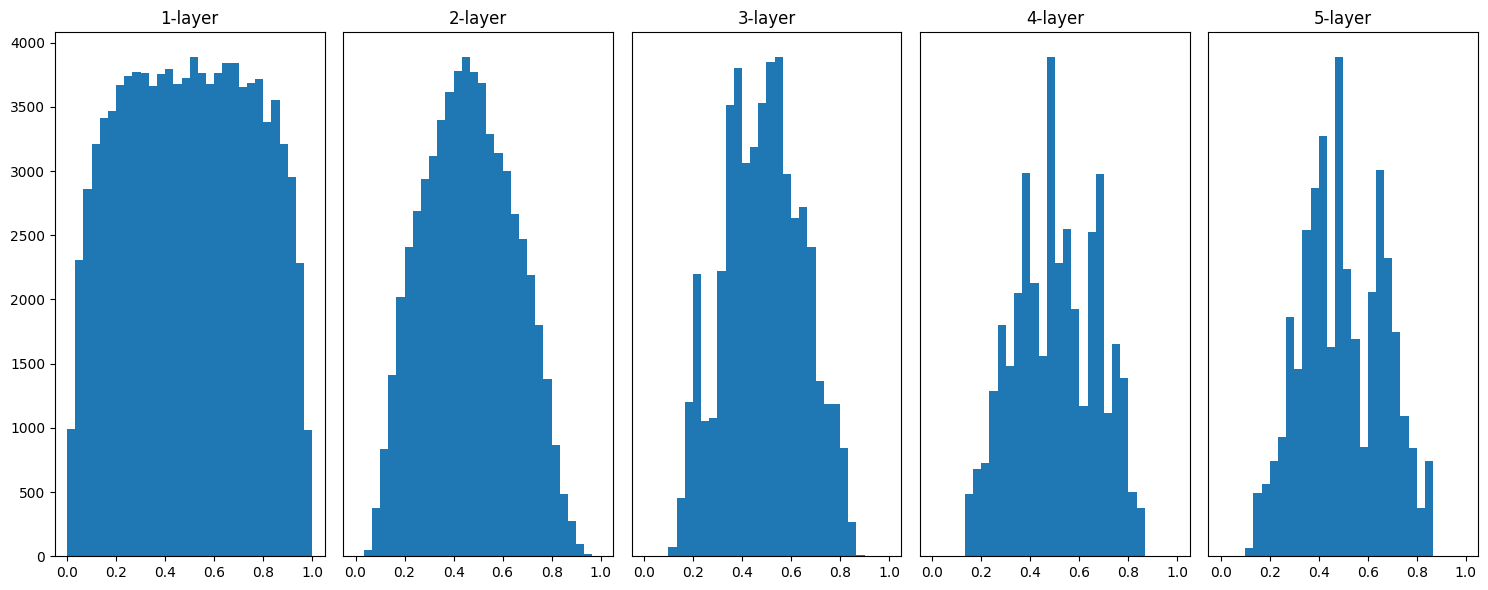

relu, 1


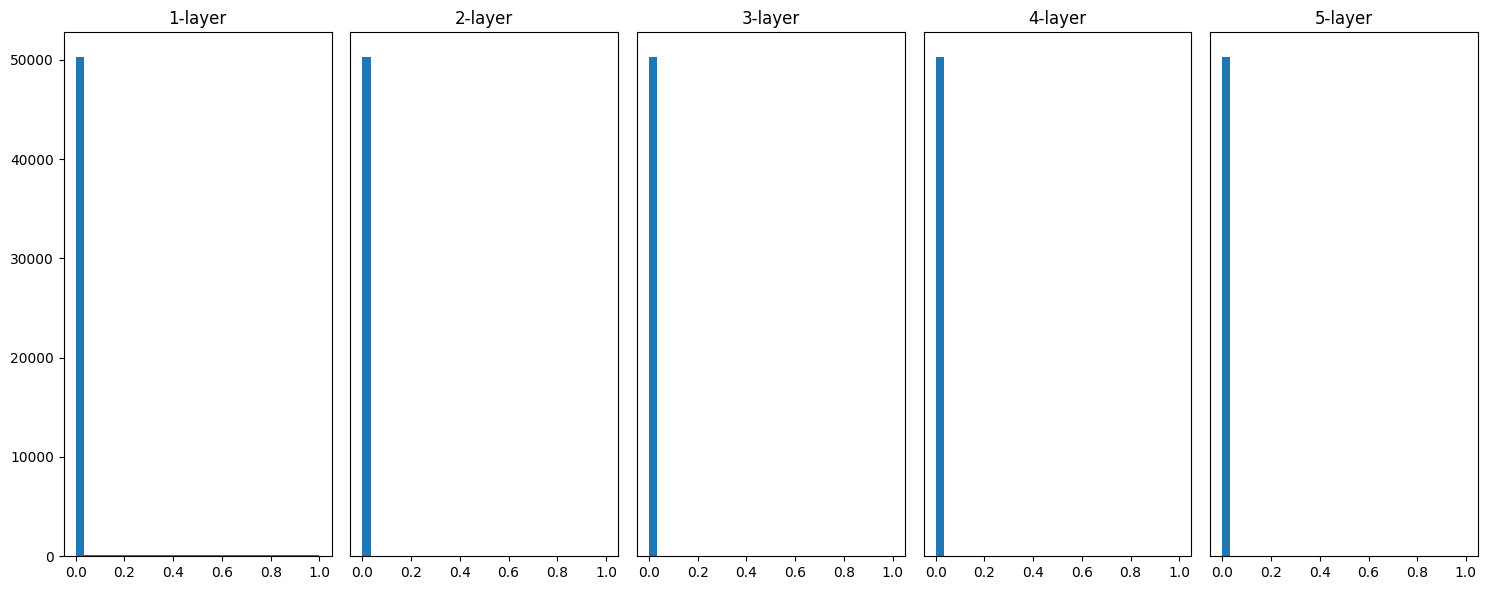

relu, 0.01


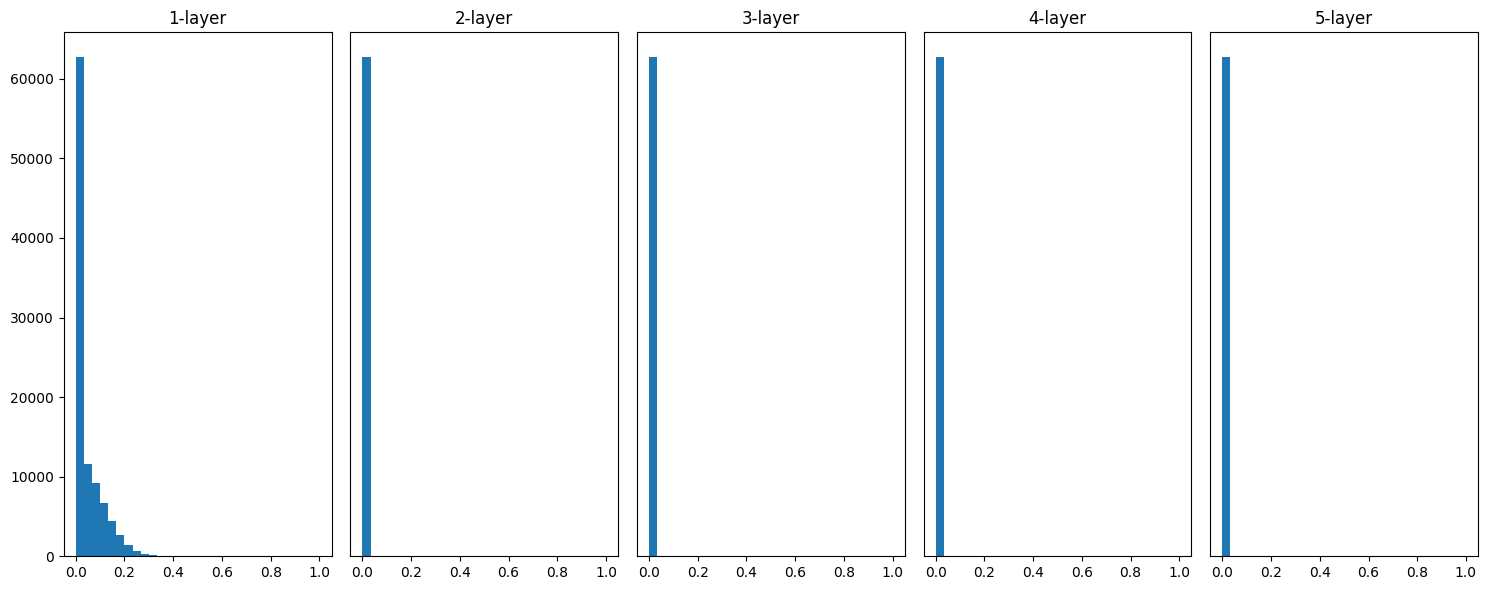

relu, Xavier : np.sqrt(1.0 / node_num)


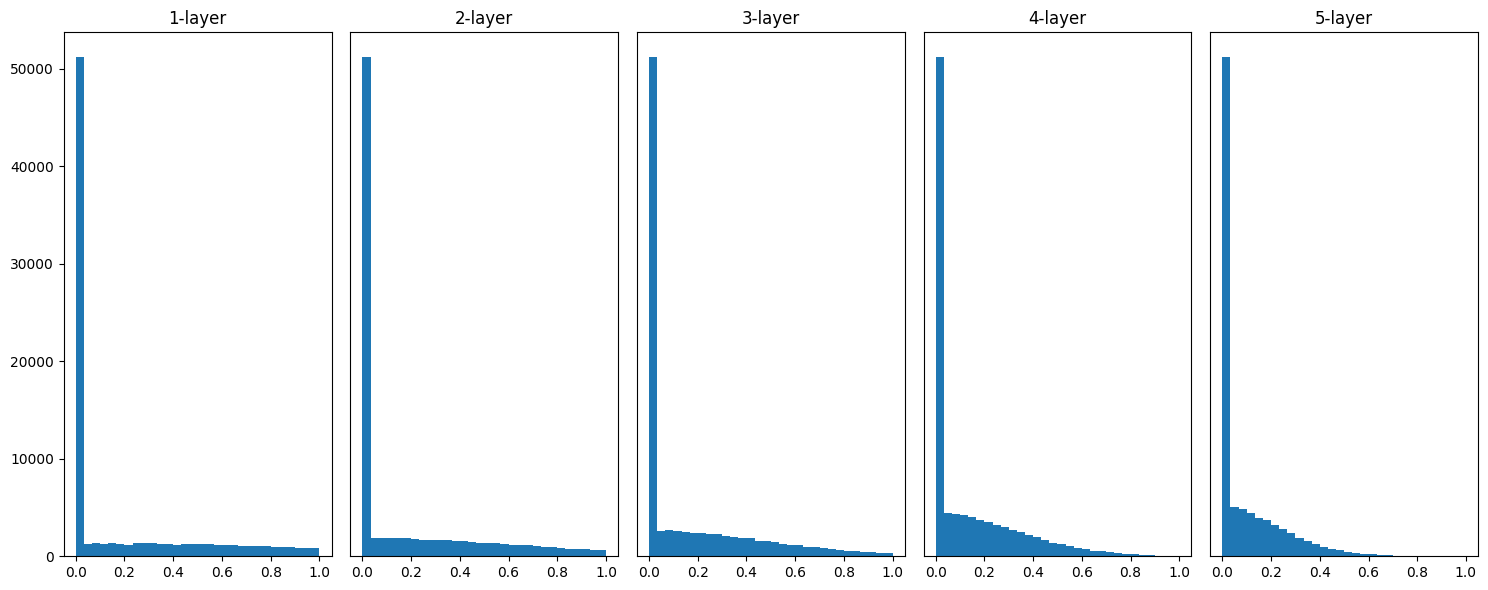

relu, He : np.sqrt(2.0 / node_num)


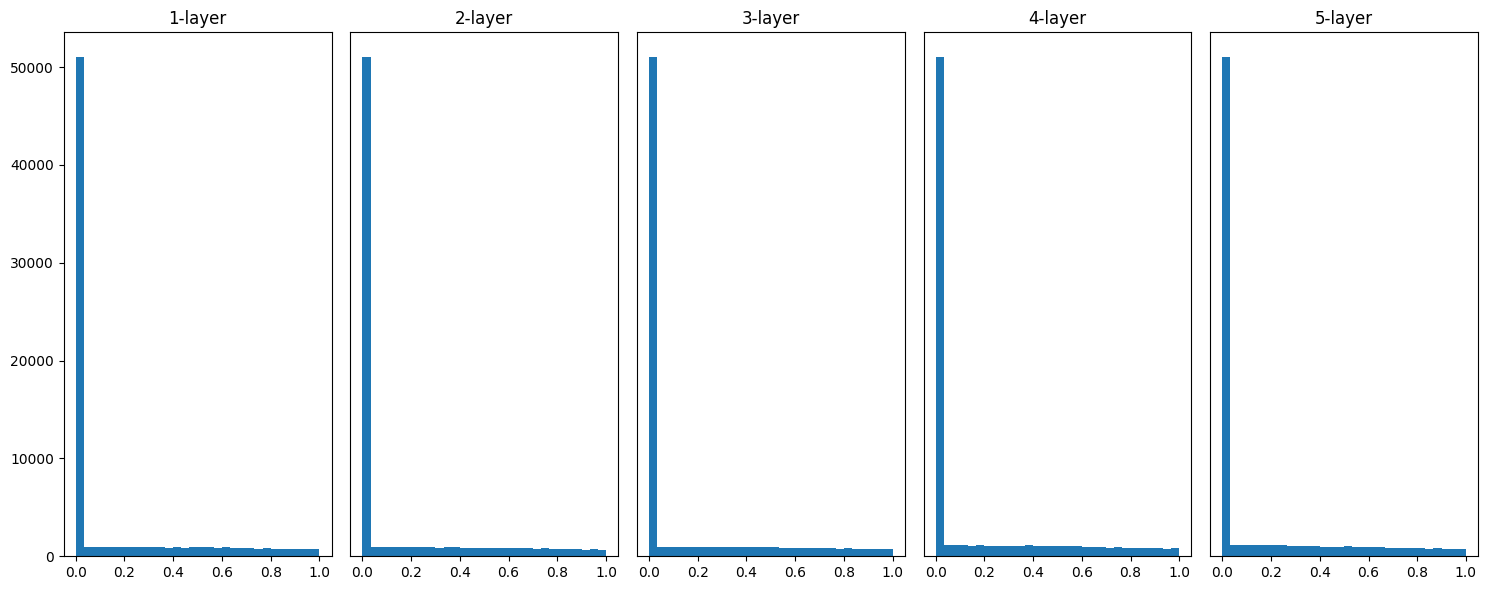

tanh, 1


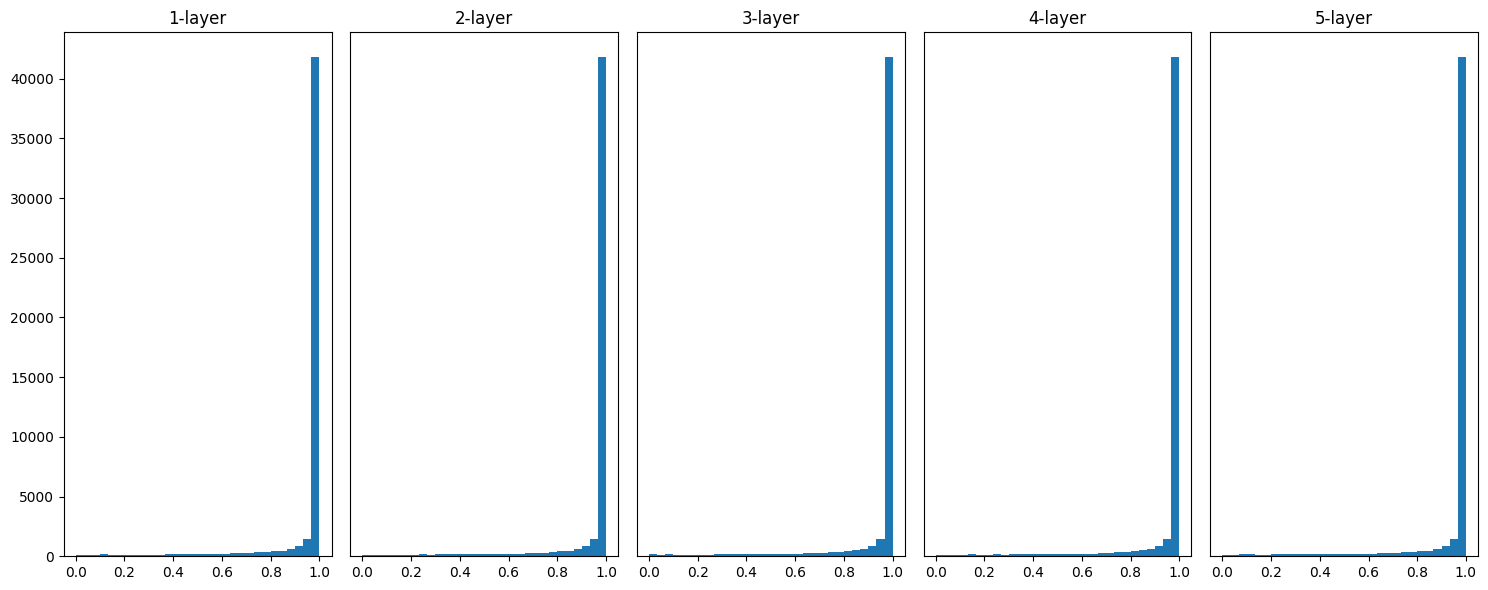

tanh, 0.01


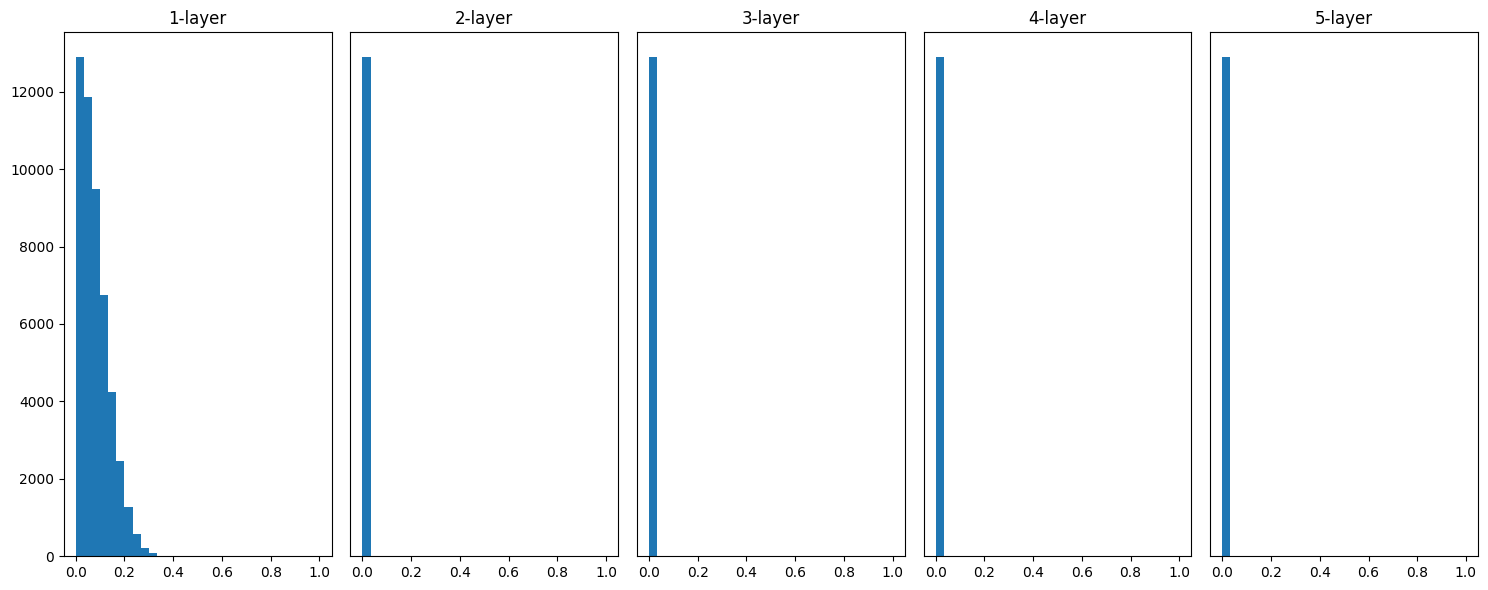

tanh, Xavier : np.sqrt(1.0 / node_num)


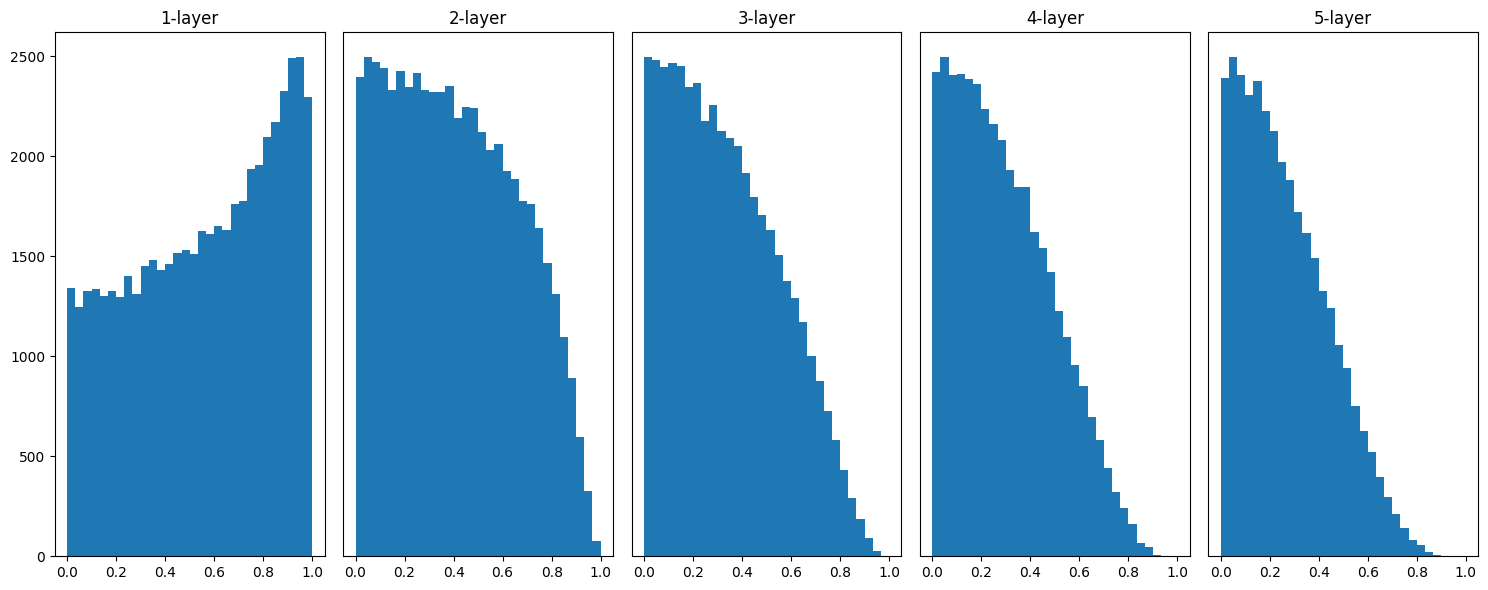

tanh, He : np.sqrt(2.0 / node_num)


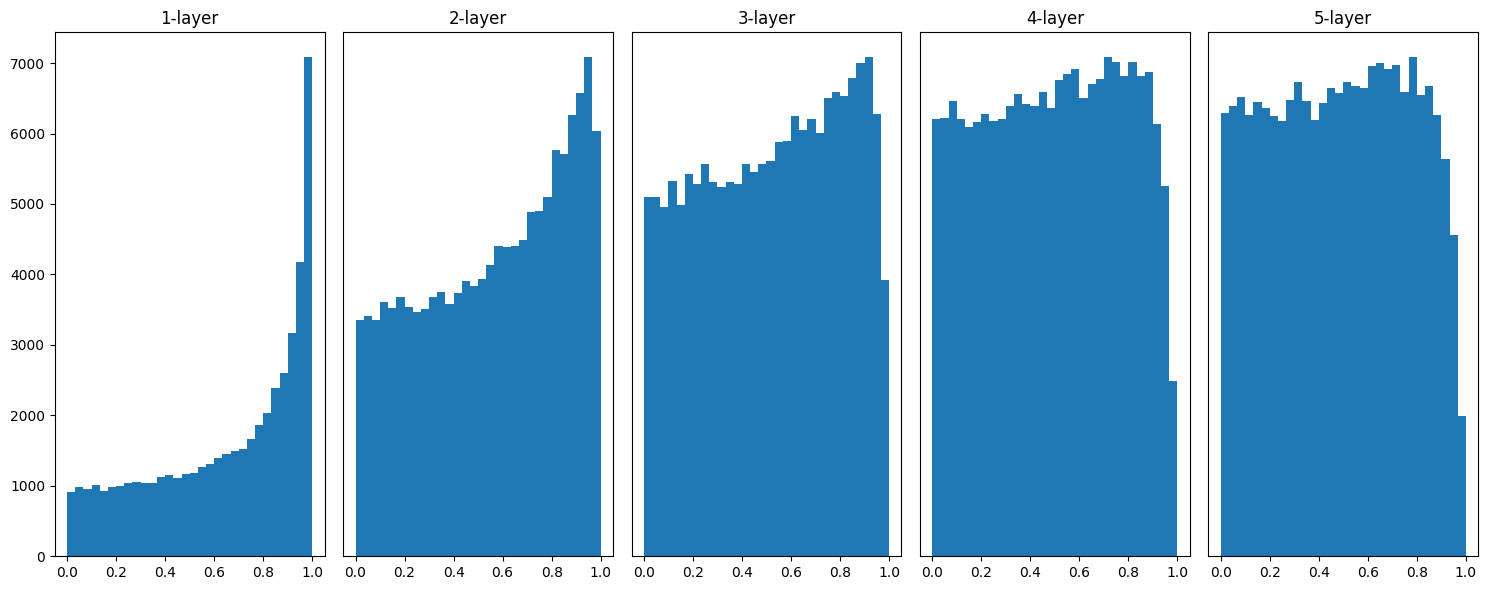

In [65]:
act_fns = ['softmax', 'relu', 'tanh']
decay_types = [1, 0.01, 'xavier', 'he']
for act_fn in act_fns:
    for decay_type in decay_types:
        show_weights(act_fn, decay_type)

## MNIST 데이터셋으로 본 가중치 초깃값 비교

### 0. MNIST 데이터 읽기

In [78]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

### 실험 설정

In [79]:
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

### 학습

In [80]:
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
std=0.01:2.30254212691161
Xavier:2.3034384288812895
He:2.444496698787182
===========iteration:100===========
std=0.01:2.303296494619161
Xavier:2.2492735056533006
He:1.934534565450876
===========iteration:200===========
std=0.01:2.3009605141345695
Xavier:2.161935920222467
He:1.061604234410726
===========iteration:300===========
std=0.01:2.3027433070558048
Xavier:1.9510041680975507
He:0.6655904422721127
===========iteration:400===========
std=0.01:2.302490837108788
Xavier:1.509364188476027
He:0.4571453919762242
===========iteration:500===========
std=0.01:2.302532542301476
Xavier:1.1657175275228675
He:0.4526965990220404
===========iteration:600===========
std=0.01:2.303746786548552
Xavier:0.8975814712570925
He:0.46051371775201067
===========iteration:700===========
std=0.01:2.3072604064390654
Xavier:0.5660083095054312
He:0.24180985855839443
===========iteration:800===========
std=0.01:2.2996620884109715
Xavier:0.6415846608772497
He:0.3993950423454976
===

### 그래프 그리기

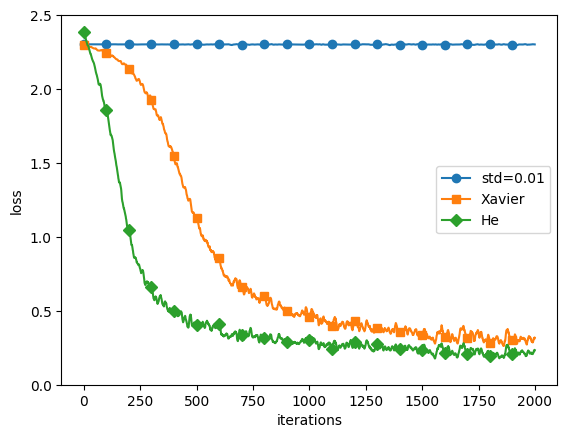

In [81]:
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

# 배치 정규화

============== 1/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 2/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 3/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 4/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 5/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 6/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 7/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 8/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 9/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 10/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 11/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 12/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 13/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 14/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 15/16 ==============


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


============== 16/16 ==============


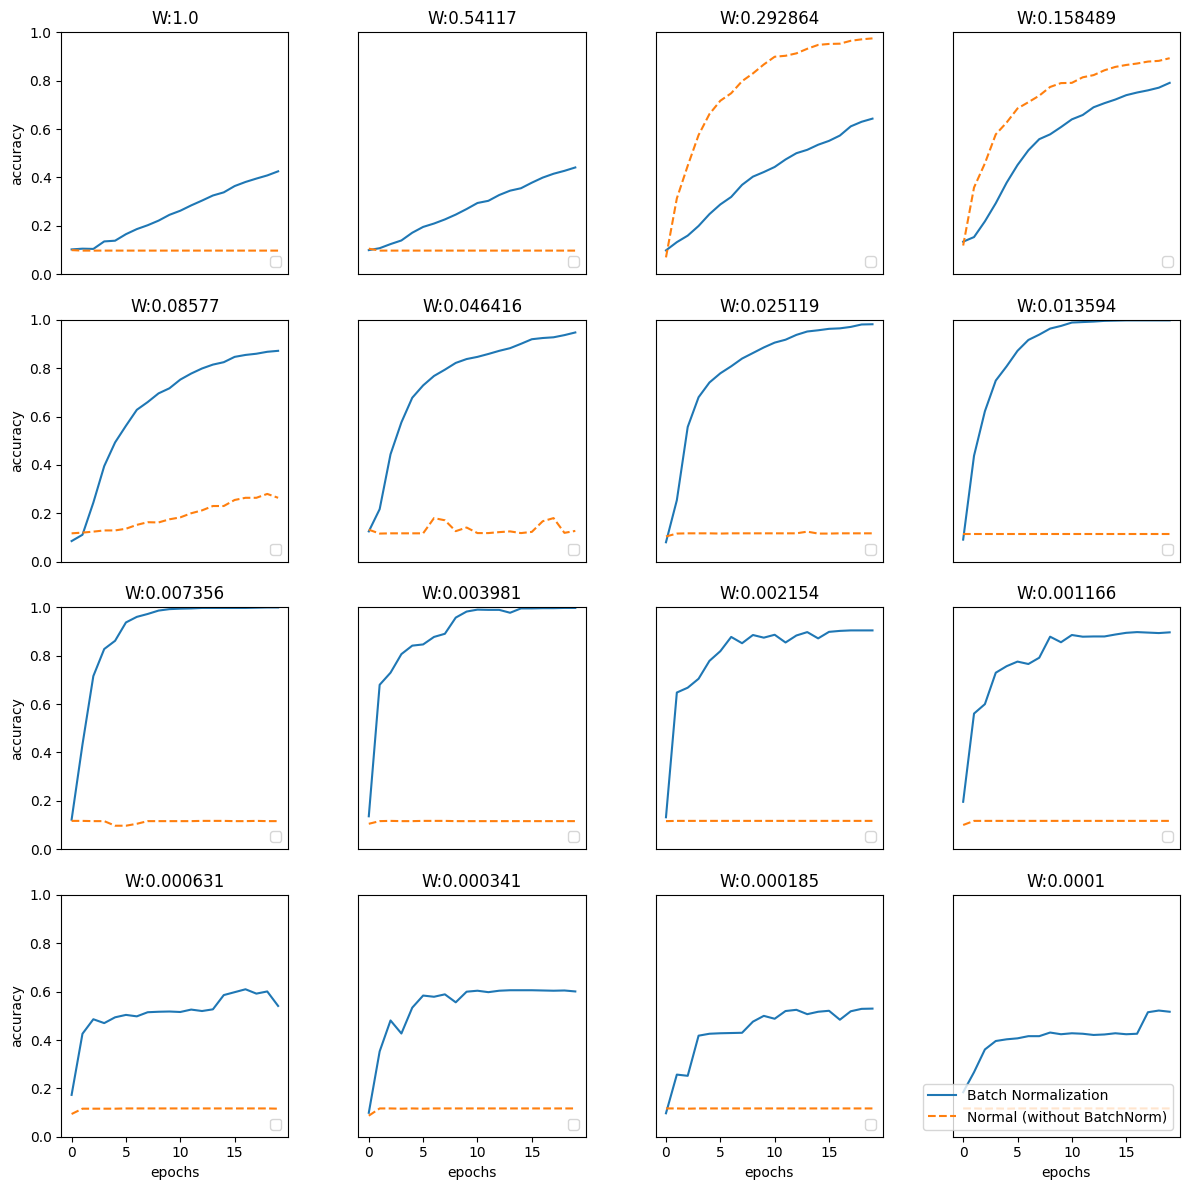

In [111]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784,
                                     hidden_size_list=[100, 100, 100, 100, 100],
                                     output_size=10,
                                     weight_init_std=weight_init_std,
                                     use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784,
                                  hidden_size_list=[100, 100, 100, 100, 100],
                                  output_size=10,
                                  weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)

    train_acc_list = []
    bn_train_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)

#             print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    return train_acc_list, bn_train_acc_list

# 그래프 그리기
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, w in enumerate(weight_scale_list):
    print("============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)

    row, col = divmod(i, 4)
    ax = axes[row, col]
    
    ax.set_title("W:" + str(np.round(w, 6)))
    
    if i == 15:
        ax.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        ax.plot(x, train_acc_list, linestyle="--", label='Normal (without BatchNorm)', markevery=2)
    else:
        ax.plot(x, bn_train_acc_list, markevery=2)
        ax.plot(x, train_acc_list, linestyle="--", markevery=2)
    
    ax.set_ylim(0, 1.0)
    
    if i % 4:
        ax.set_yticks([])
    else:
        ax.set_ylabel("accuracy")
    
    if i < 12:
        ax.set_xticks([])
    else:
        ax.set_xlabel("epochs")
    
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# 바른 학습을 위해

## 오버피팅

In [156]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

In [157]:
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

In [158]:
weight_decay_lambda = 0

In [159]:
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                       output_size=10, weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

In [160]:
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

In [161]:
iter_per_epoch = max(train_size/batch_size, 1)
epoch_cnt = 0
i = 0

In [162]:
# for i in range(1000000000):

while True:
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]    
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print("epoch:" + str(epoch_cnt) + 
              ", train acc:" + str(train_acc) + 
              ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break    
    i += 1

epoch:0, train acc:0.13666666666666666, test acc:0.1422
epoch:1, train acc:0.18333333333333332, test acc:0.1652
epoch:2, train acc:0.21333333333333335, test acc:0.1842
epoch:3, train acc:0.25666666666666665, test acc:0.2068
epoch:4, train acc:0.31, test acc:0.2453
epoch:5, train acc:0.36666666666666664, test acc:0.2858
epoch:6, train acc:0.4166666666666667, test acc:0.3211
epoch:7, train acc:0.44666666666666666, test acc:0.3381
epoch:8, train acc:0.46, test acc:0.3593
epoch:9, train acc:0.49, test acc:0.3787
epoch:10, train acc:0.51, test acc:0.3865
epoch:11, train acc:0.5466666666666666, test acc:0.3879
epoch:12, train acc:0.5466666666666666, test acc:0.4112
epoch:13, train acc:0.5833333333333334, test acc:0.4257
epoch:14, train acc:0.6133333333333333, test acc:0.4391
epoch:15, train acc:0.6233333333333333, test acc:0.4525
epoch:16, train acc:0.64, test acc:0.4691
epoch:17, train acc:0.6533333333333333, test acc:0.4837
epoch:18, train acc:0.67, test acc:0.4954
epoch:19, train acc:0.70

epoch:168, train acc:1.0, test acc:0.7665
epoch:169, train acc:1.0, test acc:0.7672
epoch:170, train acc:1.0, test acc:0.7674
epoch:171, train acc:1.0, test acc:0.7668
epoch:172, train acc:1.0, test acc:0.7667
epoch:173, train acc:1.0, test acc:0.7663
epoch:174, train acc:1.0, test acc:0.7676
epoch:175, train acc:1.0, test acc:0.7687
epoch:176, train acc:1.0, test acc:0.7686
epoch:177, train acc:1.0, test acc:0.7667
epoch:178, train acc:1.0, test acc:0.7701
epoch:179, train acc:1.0, test acc:0.7692
epoch:180, train acc:1.0, test acc:0.77
epoch:181, train acc:1.0, test acc:0.7694
epoch:182, train acc:1.0, test acc:0.7687
epoch:183, train acc:1.0, test acc:0.7685
epoch:184, train acc:1.0, test acc:0.7686
epoch:185, train acc:1.0, test acc:0.7681
epoch:186, train acc:1.0, test acc:0.7684
epoch:187, train acc:1.0, test acc:0.7679
epoch:188, train acc:1.0, test acc:0.7714
epoch:189, train acc:1.0, test acc:0.7714
epoch:190, train acc:1.0, test acc:0.7687
epoch:191, train acc:1.0, test acc:0

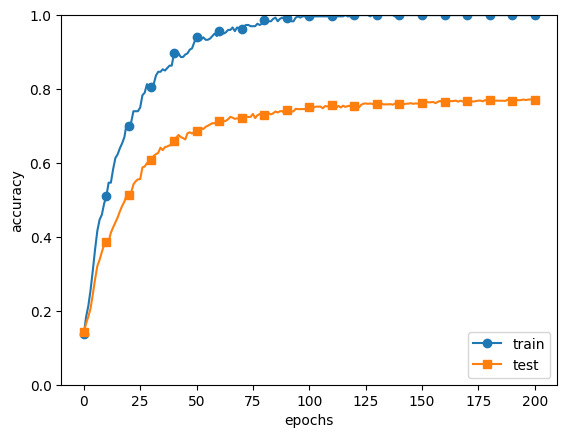

In [163]:
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 가중치 감소

In [164]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

In [165]:
# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], 
                        output_size=10, weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

In [166]:
i = 0
# for i in range(1000000000):
while True:
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break
    i+= 1

epoch:0, train acc:0.1, test acc:0.1029
epoch:1, train acc:0.13666666666666666, test acc:0.1343
epoch:2, train acc:0.15333333333333332, test acc:0.1595
epoch:3, train acc:0.20333333333333334, test acc:0.1917
epoch:4, train acc:0.25, test acc:0.223
epoch:5, train acc:0.32666666666666666, test acc:0.2585
epoch:6, train acc:0.3333333333333333, test acc:0.2738
epoch:7, train acc:0.33666666666666667, test acc:0.2866
epoch:8, train acc:0.37333333333333335, test acc:0.3092
epoch:9, train acc:0.4, test acc:0.322
epoch:10, train acc:0.41, test acc:0.343
epoch:11, train acc:0.42333333333333334, test acc:0.3495
epoch:12, train acc:0.4533333333333333, test acc:0.3812
epoch:13, train acc:0.4666666666666667, test acc:0.3899
epoch:14, train acc:0.49, test acc:0.3956
epoch:15, train acc:0.5233333333333333, test acc:0.4094
epoch:16, train acc:0.53, test acc:0.4163
epoch:17, train acc:0.5633333333333334, test acc:0.4204
epoch:18, train acc:0.5966666666666667, test acc:0.4478
epoch:19, train acc:0.606666

epoch:161, train acc:0.9433333333333334, test acc:0.7622
epoch:162, train acc:0.9366666666666666, test acc:0.7625
epoch:163, train acc:0.93, test acc:0.7624
epoch:164, train acc:0.9233333333333333, test acc:0.7565
epoch:165, train acc:0.92, test acc:0.7523
epoch:166, train acc:0.9333333333333333, test acc:0.7598
epoch:167, train acc:0.92, test acc:0.754
epoch:168, train acc:0.9333333333333333, test acc:0.7577
epoch:169, train acc:0.94, test acc:0.7498
epoch:170, train acc:0.9433333333333334, test acc:0.7541
epoch:171, train acc:0.93, test acc:0.7549
epoch:172, train acc:0.9366666666666666, test acc:0.7538
epoch:173, train acc:0.9366666666666666, test acc:0.7558
epoch:174, train acc:0.9433333333333334, test acc:0.7708
epoch:175, train acc:0.95, test acc:0.7642
epoch:176, train acc:0.9466666666666667, test acc:0.7627
epoch:177, train acc:0.95, test acc:0.7678
epoch:178, train acc:0.94, test acc:0.7666
epoch:179, train acc:0.92, test acc:0.7583
epoch:180, train acc:0.94, test acc:0.76
epo

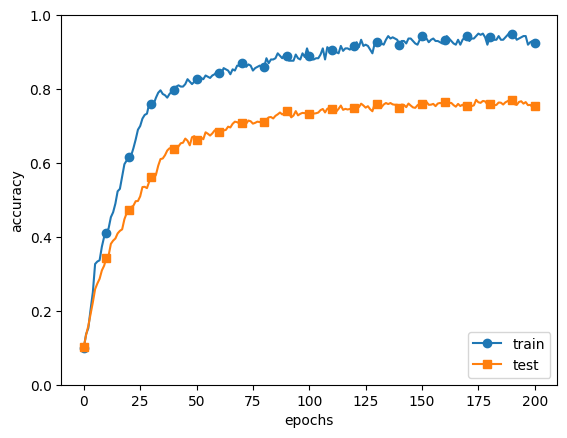

In [167]:
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 드롭아웃

In [168]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784,
                              hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout,
                              dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

train loss:2.293925476899407
=== epoch:1, train acc:0.12666666666666668, test acc:0.1143 ===
train loss:2.3135168087741333
train loss:2.310445530364607
train loss:2.3036083580353255
=== epoch:2, train acc:0.12666666666666668, test acc:0.115 ===
train loss:2.304335549557337
train loss:2.2955725320626845
train loss:2.3051659020504536
=== epoch:3, train acc:0.12666666666666668, test acc:0.1163 ===
train loss:2.316955296107032
train loss:2.3061490025675564
train loss:2.293347475296832
=== epoch:4, train acc:0.12666666666666668, test acc:0.1165 ===
train loss:2.2886223388001024
train loss:2.315356806337341
train loss:2.2956025212519076
=== epoch:5, train acc:0.12666666666666668, test acc:0.1176 ===
train loss:2.306428781111137
train loss:2.2780854617980153
train loss:2.2889171226926464
=== epoch:6, train acc:0.12666666666666668, test acc:0.1184 ===
train loss:2.33476598023995
train loss:2.2965803943917398
train loss:2.305326604592709
=== epoch:7, train acc:0.12666666666666668, test acc:0.11

=== epoch:56, train acc:0.21, test acc:0.1928 ===
train loss:2.2529902473385253
train loss:2.2676125466539943
train loss:2.2452871654178277
=== epoch:57, train acc:0.22, test acc:0.1989 ===
train loss:2.26439039517092
train loss:2.25944032760964
train loss:2.263354206575985
=== epoch:58, train acc:0.22333333333333333, test acc:0.2015 ===
train loss:2.2558496690574965
train loss:2.246235193947521
train loss:2.2459347716448494
=== epoch:59, train acc:0.20666666666666667, test acc:0.1921 ===
train loss:2.2757424409788327
train loss:2.2636740848796624
train loss:2.2511183721810597
=== epoch:60, train acc:0.21666666666666667, test acc:0.1964 ===
train loss:2.270530414438
train loss:2.261270612211253
train loss:2.251697867163357
=== epoch:61, train acc:0.23666666666666666, test acc:0.2057 ===
train loss:2.2441522293936615
train loss:2.2547097127693094
train loss:2.2607937949324124
=== epoch:62, train acc:0.24333333333333335, test acc:0.2094 ===
train loss:2.255295863277198
train loss:2.25207

=== epoch:111, train acc:0.39666666666666667, test acc:0.3202 ===
train loss:2.1100079127688027
train loss:2.1826232710456797
train loss:2.159470892294317
=== epoch:112, train acc:0.38666666666666666, test acc:0.3155 ===
train loss:2.133142938043204
train loss:2.130556848776858
train loss:2.18485025113484
=== epoch:113, train acc:0.38666666666666666, test acc:0.3161 ===
train loss:2.164842213518039
train loss:2.1910204398832454
train loss:2.1846449802081462
=== epoch:114, train acc:0.4, test acc:0.3215 ===
train loss:2.1535375228716807
train loss:2.126586948316103
train loss:2.186993253112643
=== epoch:115, train acc:0.39666666666666667, test acc:0.3203 ===
train loss:2.1411585771912875
train loss:2.1600191143307486
train loss:2.1427067285737937
=== epoch:116, train acc:0.3933333333333333, test acc:0.3172 ===
train loss:2.114081804666693
train loss:2.146415834251742
train loss:2.1383449406505237
=== epoch:117, train acc:0.38666666666666666, test acc:0.3152 ===
train loss:2.170471877005

=== epoch:166, train acc:0.48, test acc:0.3816 ===
train loss:1.9610398641512103
train loss:1.9672499257436888
train loss:1.9439170272609405
=== epoch:167, train acc:0.47333333333333333, test acc:0.3817 ===
train loss:2.031574502110315
train loss:1.9901034525691872
train loss:2.0096614119574223
=== epoch:168, train acc:0.49333333333333335, test acc:0.3876 ===
train loss:1.970573392198296
train loss:2.0176144291944498
train loss:1.9967019959599117
=== epoch:169, train acc:0.49333333333333335, test acc:0.3901 ===
train loss:1.917130537058041
train loss:1.9235378313331817
train loss:1.907183378489361
=== epoch:170, train acc:0.4866666666666667, test acc:0.3862 ===
train loss:1.9524383103679563
train loss:1.9561471592823787
train loss:1.955483345269154
=== epoch:171, train acc:0.49666666666666665, test acc:0.3913 ===
train loss:1.8885173221189318
train loss:1.9491413556381563
train loss:1.9114974909597058
=== epoch:172, train acc:0.49333333333333335, test acc:0.389 ===
train loss:1.8480418

=== epoch:221, train acc:0.54, test acc:0.4373 ===
train loss:1.826748384091636
train loss:1.6481892962337457
train loss:1.6784491099834447
=== epoch:222, train acc:0.5466666666666666, test acc:0.4435 ===
train loss:1.6801010175226565
train loss:1.6371970212563685
train loss:1.755417215653119
=== epoch:223, train acc:0.5433333333333333, test acc:0.4451 ===
train loss:1.7812160521509421
train loss:1.662672127690717
train loss:1.7246591809230893
=== epoch:224, train acc:0.5533333333333333, test acc:0.4448 ===
train loss:1.59552031282406
train loss:1.717239566374209
train loss:1.7369872903658854
=== epoch:225, train acc:0.5466666666666666, test acc:0.4444 ===
train loss:1.7425801551440088
train loss:1.6671730512364846
train loss:1.6059070895329097
=== epoch:226, train acc:0.5466666666666666, test acc:0.447 ===
train loss:1.6605316682340874
train loss:1.7052462522737206
train loss:1.7896347208980492
=== epoch:227, train acc:0.5566666666666666, test acc:0.4497 ===
train loss:1.6401614361217

=== epoch:276, train acc:0.6333333333333333, test acc:0.4908 ===
train loss:1.4023344393984742
train loss:1.4083473942004605
train loss:1.3924823222927276
=== epoch:277, train acc:0.6466666666666666, test acc:0.4952 ===
train loss:1.3956000274230516
train loss:1.3151071011942093
train loss:1.249408286115449
=== epoch:278, train acc:0.64, test acc:0.4962 ===
train loss:1.4636090064890368
train loss:1.4042939618973633
train loss:1.328262605263066
=== epoch:279, train acc:0.6366666666666667, test acc:0.4978 ===
train loss:1.3133313566370919
train loss:1.4824550809960149
train loss:1.3967772836666041
=== epoch:280, train acc:0.6466666666666666, test acc:0.4991 ===
train loss:1.3855277392606486
train loss:1.412455037957514
train loss:1.4483759297521572
=== epoch:281, train acc:0.65, test acc:0.5024 ===
train loss:1.4043885263240619
train loss:1.4094125670667388
train loss:1.4020849344592188
=== epoch:282, train acc:0.65, test acc:0.503 ===
train loss:1.375544046153342
train loss:1.347687015

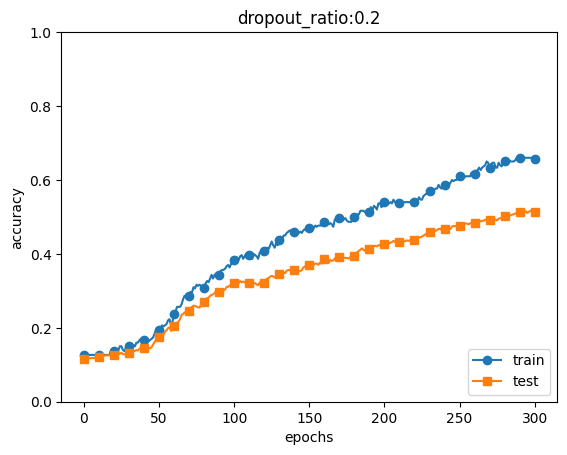

In [170]:
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title(f'dropout_ratio:{dropout_ratio}')
plt.show()
# epoch:301, train acc:0.73, test acc:0.6315

# 적절한 하이퍼파라미터 값 찾기

## 검증 데이터

In [172]:
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

x_train, t_train = shuffle_dataset(x_train, t_train)

In [173]:
validation_rate = 0.2
validation_num = int(x_train.shape[0]*validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

x_train.shape, t_train.shape, x_val.shape, t_val.shape

((48000, 784), (48000,), (12000, 784), (12000,))

In [174]:
from sklearn.model_selection import train_test_split

In [175]:
(x_train, t_train), (x_test, t_test) = load_mnist()

X_train, X_val, y_train, y_val = train_test_split(x_train, t_train, test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((48000, 784), (12000, 784), (48000,), (12000,))

## 하이퍼파라미터 최적화

In [178]:
# coding: utf-8
import sys
import os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

In [179]:
from tqdm import tqdm

def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784,
                            hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd',
                      optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in tqdm(range(optimization_trial)):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
#     print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

100%|█████████████████████████████████████████| 100/100 [04:07<00:00,  2.48s/it]


=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.81) | lr:0.008796817832768242, weight decay:1.2975029587469513e-06
Best-2(val acc:0.8) | lr:0.008795620797652295, weight decay:8.282624590741943e-06
Best-3(val acc:0.74) | lr:0.007760487103546243, weight decay:2.0119658637110925e-06
Best-4(val acc:0.74) | lr:0.00544636701051911, weight decay:1.9701554198648632e-05
Best-5(val acc:0.62) | lr:0.0042409789355616345, weight decay:2.2914484168052976e-06
Best-6(val acc:0.54) | lr:0.003523310004186838, weight decay:8.707730563905278e-08
Best-7(val acc:0.51) | lr:0.004156482193161646, weight decay:8.998780436040645e-08
Best-8(val acc:0.49) | lr:0.0033522596255287133, weight decay:5.984343801221819e-08
Best-9(val acc:0.48) | lr:0.0032433726158049864, weight decay:1.4124984039376882e-06
Best-10(val acc:0.42) | lr:0.0014359109322173214, weight decay:9.04874896559975e-07
Best-11(val acc:0.38) | lr:0.0023334362991604637, weight decay:5.21843484420116e-08
Best-12(val acc:0.3

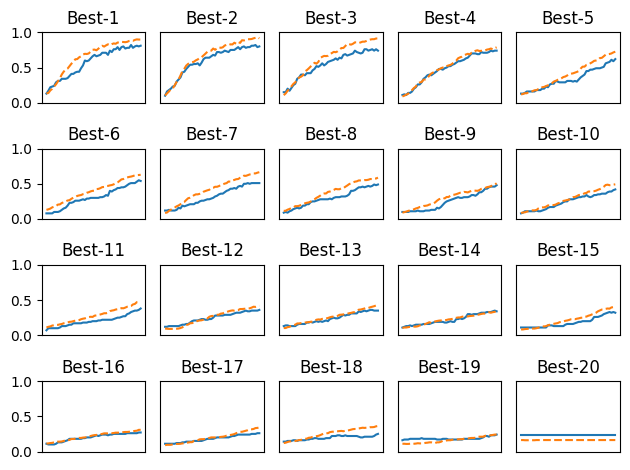

In [181]:
# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x: x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5:
        plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.tight_layout()
plt.show()